### Things to try
- Using Cabin and Ticket as features

In [1]:
import pandas as pd

# Preprocessing

### Import Data

In [36]:
titanic_train = pd.read_csv('train.csv')
titanic_test = pd.read_csv('test.csv')

full_set = titanic_train.append(titanic_test)

y = titanic_train.Survived
#X = full_set.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
X = full_set.drop(['PassengerId', 'Survived', 'Name', 'Ticket'], axis=1)

In [37]:
from sklearn.preprocessing import Imputer

def preprocess_data(X):
    # Add dataframe columns signifying where missing data is located......    
    cols_with_missing = (col for col in X.columns if X[col].isnull().any()) # Get columns with missing data

    for col in cols_with_missing:
        X[col + '_missing'] = X[col].isnull()
        
    # One hot encode data..................................................
    ohe_X = pd.get_dummies(X)
    
    # Fit missing data using imputation....................................
    imputer = Imputer()
    imputed_X = pd.DataFrame(imputer.fit_transform(ohe_X))
    imputed_X.columns = ohe_X.columns
    
    return imputed_X

In [38]:
X = preprocess_data(X)
titanic_X = X[:len(titanic_train)]
titanic_test_X = X[len(titanic_train):]

### Train Test Split

In [39]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(titanic_X.values, y.values, test_size=0.2)

# Train Data

### Find optimal model cycle count n_estimators

In [40]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

test_range = range(100, 30000, 1000)

val_mean_error = []
train_mean_error = []
for n in test_range:  
    model = XGBRegressor(n_estimators=n, learning_rate=.01)
    model.fit(train_X, train_y,)

    predictions = model.predict(val_X)
    val_mean_error += [mean_absolute_error(predictions, val_y)]
    
    predictions = model.predict(train_X)
    train_mean_error += [mean_absolute_error(predictions, train_y)]

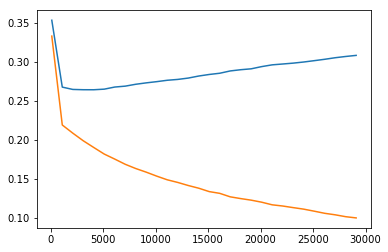

In [41]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(test_range, val_mean_error, test_range, train_mean_error)
plt.show()

In [32]:
val_mean_error[5]

0.2540805409740469

# Train Full Data Set

In [33]:
# Train on full data set with optimal model cycle count
model = XGBRegressor(n_estimators=5000, learning_rate=.01)
model.fit(titanic_X.values, y.values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=5000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

# Predict on Test Set

In [34]:
final_predictions = model.predict(titanic_test_X.values)

# Convert to boolean values
final_bool = [1 if p > 0.5 else 0 for p in final_predictions]

In [35]:
# Export predictions for submission
output = pd.DataFrame({'PassengerId': titanic_test.PassengerId, 'Survived': final_bool})
output.to_csv('submission.csv', index=False)